##Midterm 1 - Assignment 5 (Luca Marini)

In [ ]:
#connect to google drive to import the images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import glob
from matplotlib import pyplot as plt

##Images selection and extraction of SIFT descriptors
I get the images from classes 1, 4, 6 and 7.
<br>Then I obtain the <b>gray scale</b> version of them. The resulting images are exploited to calculate the <b>points of interest</b> and their relative <b>descriptors</b>.

In [ ]:
# select four subclasses of images and extract sift descriptors of the points of interest

classes = [1, 4, 6, 7] #categories of the images I want to work with
images = []
gray_images = []
descriptors_class = [] #category of the image which each descriptor belong to
image_class = [] #category of each image
descriptors = []
key_points = []

sift = cv2.xfeatures2d.SIFT_create()

for i in range(len(classes)):
  for im in sorted(glob.glob('/content/drive/MyDrive/MSRC_ObjCategImageDatabase_v1/[' + str(classes[i]) + ']*[!_GT].bmp')): #consider each image of the four chosen classes
    #get the image
    img = cv2.imread(im)
    images.append(img)

    image_class.append(classes[i]) #give to each image its class

    #get the gray scale version of the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray)

    #get descriptor and keypoints of the image
    kp, des = sift.detectAndCompute(gray, None)
    descriptors.append(des)
    key_points.append(kp)

    descriptors_class.extend(classes[i] for _ in range(len(des))) #give to each descriptor the class of the image of the point of interest it's representing


In [ ]:
for i in range(16):
  print(descriptors[1][0][i])

3.0
0.0
0.0
0.0
0.0
0.0
0.0
2.0
6.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0


##Show reslut of previous code in the last image of my dataset

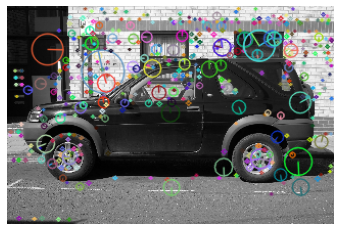

In [ ]:
img_index = len(gray_images) - 1
image = cv2.drawKeypoints(gray_images[img_index], key_points[img_index], images[img_index], flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image)
plt.axis("off")
plt.show()

##Run k-means and extract result
I run <b>k-means</b> with a different number of clusters in order to observe the different clustering behavior. The algorithm is executed with k = 4, 16, 200, 500, 2000
<br>After that I analyze the results, calculating the following metrics:

*   A coefficient that show the variation of the number of descriptors in each cluster;
*   For each cluster, the ratio between the percentage of descriptors of the class with maximum percentage and the average of the percentage of descriptors from every class (to check the number of cluster where it's over a certain threshold);
*   For each cluster, the ratio between the percentage of descriptors of the class with minimum percentage and the average of the percentage of descriptors from every class (to check the number of cluster where it's under a certain threshold);
*   Accuracy of the clusterization (for k = 4);
*   How many (and which) clusters have a number of descriptors from a certain class that is >= of the number of descriptors from the other classes (majorities) (for k = 200, 500, 2000);
*   How many (and which) clusters have 0 descriptors from a certain class (for k = 200, 500, 2000).

<br>After each block of code, in which k-means is executed, it's shown (all or part of) the confusion matrix.





In [ ]:
from sklearn.cluster import KMeans
import numpy as np

X = np.concatenate(descriptors) #aggregate all the descriptors in a dataset
#test parameters
threshold_max = 1.75
threshold_min = 0.375

In [ ]:
#count all the descriptors for each class, without assuming they're sorted
sums = [0] * len(classes)
for c in range(len(classes)):
  for i in range(len(images)):
    if image_class[i] == classes[c]:
      sums[c] += len(key_points[i])

print(sums)

[9948, 7750, 10236, 13807]


In [ ]:
K = 4

# run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)


# CHECK RESULTS

#calculate confusion matrix and how many descriptors of each class (in percentage) are included in each cluster
percentage_per_cluster = np.zeros((K, len(classes)))
confusion_matrix = np.zeros((K, len(classes)))
item_per_cluster = [0] * K #counter of descriptors in the cluster
#compute confusion matrix
for i in range(K):
  for j in range(X.shape[0]):
    if kmeans.labels_[j] == i:
      for c in range(len(classes)):
        if descriptors_class[j] == classes[c]:
          confusion_matrix[i][c] += 1
          break

  #calculate the percentage
  for c in range(len(classes)):
    percentage_per_cluster[i][c] = confusion_matrix[i][c] * 100 / sums[c]

#get number of descriptor included in each cluster
for i in range(K):
  item_per_cluster[i] = np.sum(confusion_matrix[i])

#check the variation in clusters dimesion
print("Coefficient of variation of number of descriptors in each cluster: " + str(np.std(item_per_cluster) / np.average(item_per_cluster)))

#check hom much the max and the min percentage of the descriptors from each class differ from the average
difference_in_cluster = [(0,0)] * K
for i in range(K):
  max = np.max(percentage_per_cluster[i])
  min = np.min(percentage_per_cluster[i])
  avg = np.average(percentage_per_cluster[i])
  difference_in_cluster[i] = (max / avg, min / avg)
#print output
print("\nclusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster:")
max_ok = 0
min_ok = 0
for i in range(K):
  if(difference_in_cluster[i][0] >= threshold_max):
    print("\t" + str(difference_in_cluster[i][0]) + " - cluster " + str(i + 1))
    max_ok += 1
print("tot: " + str(max_ok) + "\n")
print("\nclusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster:")
for i in range(K):
  if(difference_in_cluster[i][1] <= threshold_min):
    print("\t" + str(difference_in_cluster[i][1]) + " - cluster " + str(i + 1))
    min_ok += 1
print("tot: " + str(min_ok) + "\n")

Coefficient of variation of number of descriptors in each cluster: 0.2582587443216813

clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster:
tot: 0


clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster:
tot: 0



In [ ]:
#cluster 1 --> class 6 (adapted)
#cluster 2 --> class 4
#cluster 3 --> class 1
#cluster 4 --> class 7
cluster_class_corrispondence = [2, 1, 0, 3] #based on results with K = 4 = num. of classes

#compute accuracy
well_classified = 0
for i in range(K):
  well_classified += confusion_matrix[i][cluster_class_corrispondence[i]]


#print output
print("Confusion matrix (clusters on the rows, classes 1-4-6-7 on the columns):")
print(confusion_matrix)
print("\nAccuracy: " + str(well_classified * 100 / len(descriptors_class)) + "%")
print("\nPercentage of descriptor of each class in each cluster (clusters on the rows, classes 1-4-6-7 on the columns):")
print(percentage_per_cluster)

Confusion matrix (clusters on the rows, classes 1-4-6-7 on the columns):
[[1383. 1549. 1587. 2223.]
 [1762. 2428. 2375. 3097.]
 [3689. 1494. 2627. 3303.]
 [3114. 2279. 3647. 5184.]]

Accuracy: 30.87611700725905%

Percentage of descriptor of each class in each cluster (clusters on the rows, classes 1-4-6-7 on the columns):
[[13.90229192 19.98709677 15.50410317 16.10052872]
 [17.71210294 31.32903226 23.20242282 22.43065112]
 [37.08283072 19.27741935 25.664322   23.92264793]
 [31.30277443 29.40645161 35.62915201 37.54617223]]


In [ ]:
K = 16

# run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)


# CHECK RESULTS

#calculate confusion matrix and how many descriptors of each class (in percentage) are included in each cluster
percentage_per_cluster = np.zeros((K, len(classes)))
confusion_matrix = np.zeros((K, len(classes)))
item_per_cluster = [0] * K #counter of descriptors in the cluster
#compute confusion matrix
for i in range(K):
  for j in range(X.shape[0]):
    if kmeans.labels_[j] == i:
      for c in range(len(classes)):
        if descriptors_class[j] == classes[c]:
          confusion_matrix[i][c] += 1
          break

  #calculate the percentage
  for c in range(len(classes)):
    percentage_per_cluster[i][c] = confusion_matrix[i][c] * 100 / sums[c]

#get number of descriptor included in each cluster
for i in range(K):
  item_per_cluster[i] = np.sum(confusion_matrix[i])

#check the variation in clusters dimesion
print("Coefficient of variation of number of descriptors in each cluster: " + str(np.std(item_per_cluster) / np.average(item_per_cluster)))

#check hom much the max and the min percentage of the descriptors from each class differ from the average
difference_in_cluster = [(0,0)] * K
for i in range(K):
  max = np.max(percentage_per_cluster[i])
  min = np.min(percentage_per_cluster[i])
  avg = np.average(percentage_per_cluster[i])
  difference_in_cluster[i] = (max / avg, min / avg)
#print output
print("\nclusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster:")
max_ok = 0
min_ok = 0
for i in range(K):
  if(difference_in_cluster[i][0] >= threshold_max):
    print("\t" + str(difference_in_cluster[i][0]) + " - cluster " + str(i + 1))
    max_ok += 1
print("tot: " + str(max_ok) + "\n")
print("\nclusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster:")
for i in range(K):
  if(difference_in_cluster[i][1] <= threshold_min):
    print("\t" + str(difference_in_cluster[i][1]) + " - cluster " + str(i + 1))
    min_ok += 1
print("tot: " + str(min_ok) + "\n")

Coefficient of variation of number of descriptors in each cluster: 0.20842837206000314

clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster:
	1.953364064433987 - cluster 9
tot: 1


clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster:
tot: 0



In [ ]:
K = 200

#run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)


# CHECK RESULTS

#calculate confusion matrix and how many descriptors of each class (in percentage) are included in each cluster
percentage_per_cluster = np.zeros((K, len(classes)))
confusion_matrix = np.zeros((K, len(classes)))
item_per_cluster = [0] * K #counter of descriptors in the cluster
majorities = []
#compute confusion matrix
for i in range(K):
  for j in range(X.shape[0]):
    if kmeans.labels_[j] == i:
      for c in range(len(classes)):
        if descriptors_class[j] == classes[c]:
          confusion_matrix[i][c] += 1
          break

  #calculate the percentage
  for c in range(len(classes)):
    percentage_per_cluster[i][c] = confusion_matrix[i][c] * 100 / sums[c]

  #check majority of a certain class descriptors
  max_i_c = np.max(confusion_matrix[i])
  if(max_i_c >= (np.sum(confusion_matrix[i], initial = -max_i_c))):
    majorities.append(i)

#get number of descriptor included in each cluster
for i in range(K):
  item_per_cluster[i] = np.sum(confusion_matrix[i])

#check the variation in clusters dimesion
print("Coefficient of variation of number of descriptors in each cluster: " + str(np.std(item_per_cluster) / np.average(item_per_cluster)))

#check hom much the max and the min percentage of the descriptors from each class differ from the average
difference_in_cluster = [(0,0)] * K
for i in range(K):
  max = np.max(percentage_per_cluster[i])
  min = np.min(percentage_per_cluster[i])
  avg = np.average(percentage_per_cluster[i])
  difference_in_cluster[i] = (max / avg, min / avg)
#print output
print("\nmajorities:")
max_ok = 0
min_ok = 0
for i in range(K):
  if(difference_in_cluster[i][0] >= threshold_max):
    max_ok += 1
    if(i in majorities):
      print("\t" + str(difference_in_cluster[i][0]) + " - cluster " + str(i + 1))
print("\t(" + str(len(majorities)) + ")")
print("number of clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster: " + str(max_ok) + "\n")
print("zeros:")
zeros = 0
for i in range(K):
  if(difference_in_cluster[i][1] <= threshold_min):
    min_ok += 1
    if 0 in percentage_per_cluster[i]:
      print("\t - cluster " + str(i + 1))
      zeros += 1
print("\t(" + str(zeros) + ")")
print("number of clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster: " + str(min_ok) + "\n")

Coefficient of variation of number of descriptors in each cluster: 0.2869682985622133

majorities:
	2.3738035810608653 - cluster 13
	2.1194114193646434 - cluster 15
	2.395443392992449 - cluster 24
	2.523412492377054 - cluster 46
	2.0832096567054306 - cluster 101
	2.4227524437151575 - cluster 113
	2.1895643230060386 - cluster 149
	1.7812070976917214 - cluster 158
	2.336814148495132 - cluster 168
	1.7541488037365442 - cluster 186
	(11)
number of clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster: 30

zeros:
	(0)
number of clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster: 19



In [ ]:
K = 500

# run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)


# CHECK RESULTS

#calculate confusion matrix and how many descriptors of each class (in percentage) are included in each cluster
percentage_per_cluster = np.zeros((K, len(classes)))
confusion_matrix = np.zeros((K, len(classes)))
item_per_cluster = [0] * K #counter of descriptors in the cluster
majorities = []
#compute confusion matrix
for i in range(K):
  for j in range(X.shape[0]):
    if kmeans.labels_[j] == i:
      for c in range(len(classes)):
        if descriptors_class[j] == classes[c]:
          confusion_matrix[i][c] += 1
          break

  #calculate the percentage
  for c in range(len(classes)):
    percentage_per_cluster[i][c] = confusion_matrix[i][c] * 100 / sums[c]

  #check majority of a certain class descriptors
  max_i_c = np.max(confusion_matrix[i])
  if(max_i_c >= (np.sum(confusion_matrix[i], initial = -max_i_c))):
    majorities.append(i)

#get number of descriptor included in each cluster
for i in range(K):
  item_per_cluster[i] = np.sum(confusion_matrix[i])

#check the variation in clusters dimesion
print("Coefficient of variation of number of descriptors in each cluster: " + str(np.std(item_per_cluster) / np.average(item_per_cluster)))

#check hom much the max and the min percentage of the descriptors from each class differ from the average
difference_in_cluster = [(0,0)] * K
for i in range(K):
  max = np.max(percentage_per_cluster[i])
  min = np.min(percentage_per_cluster[i])
  avg = np.average(percentage_per_cluster[i])
  difference_in_cluster[i] = (max / avg, min / avg)
#print output
print("\nmajorities:")
max_ok = 0
min_ok = 0
for i in range(K):
  if(difference_in_cluster[i][0] >= threshold_max):
    max_ok += 1
    if(i in majorities):
      print("\t" + str(difference_in_cluster[i][0]) + " - cluster " + str(i + 1))
print("\t(" + str(len(majorities)) + ")")
print("number of clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster: " + str(max_ok) + "\n")
print("zeros:")
zeros = 0
for i in range(K):
  if(difference_in_cluster[i][1] <= threshold_min):
    min_ok += 1
    if 0 in percentage_per_cluster[i]:
      print("\t - cluster " + str(i + 1))
      zeros += 1
print("\t(" + str(zeros) + ")")
print("number of clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster: " + str(min_ok) + "\n")

Coefficient of variation of number of descriptors in each cluster: 0.35409723683075084

majorities:
	2.223853355404736 - cluster 6
	1.8122239982247001 - cluster 15
	2.1324159503799702 - cluster 33
	2.108736566588724 - cluster 37
	2.211901194707063 - cluster 47
	2.2649816384958035 - cluster 49
	2.7266860768610006 - cluster 56
	2.0678114875625604 - cluster 61
	2.545845718371313 - cluster 64
	2.2251818892739914 - cluster 77
	1.7888708927663604 - cluster 78
	2.16770672342308 - cluster 84
	2.4400441155632198 - cluster 90
	2.382317202006511 - cluster 104
	2.2465709942059546 - cluster 111
	1.8088770360125035 - cluster 119
	2.1705987332557037 - cluster 121
	1.7946844250531857 - cluster 138
	2.5826992816684635 - cluster 148
	2.3825028757804283 - cluster 153
	2.651656044398211 - cluster 159
	2.2142318485628656 - cluster 177
	2.129884499513216 - cluster 178
	2.196358649102091 - cluster 183
	2.1377596995660624 - cluster 185
	1.923764516079731 - cluster 203
	2.451362970175628 - cluster 229
	2.47561

In [ ]:
K = 2000

# run k-means
kmeans = KMeans(n_clusters = K, random_state = 0, init = "k-means++", n_init = "auto").fit(X)


# CHECK RESULTS

#calculate confusion matrix and how many descriptors of each class (in percentage) are included in each cluster
percentage_per_cluster = np.zeros((K, len(classes)))
confusion_matrix = np.zeros((K, len(classes)))
item_per_cluster = [0] * K #counter of descriptors in the cluster
majorities = []
#compute confusion matrix
for i in range(K):
  for j in range(X.shape[0]):
    if kmeans.labels_[j] == i:
      for c in range(len(classes)):
        if descriptors_class[j] == classes[c]:
          confusion_matrix[i][c] += 1
          break

  #calculate the percentage
  for c in range(len(classes)):
    percentage_per_cluster[i][c] = confusion_matrix[i][c] * 100 / sums[c]

  #check majority of a certain class descriptors
  max_i_c = np.max(confusion_matrix[i])
  if(max_i_c >= (np.sum(confusion_matrix[i], initial = -max_i_c))):
    majorities.append(i)

#get number of descriptor included in each cluster
for i in range(K):
  item_per_cluster[i] = np.sum(confusion_matrix[i])

#check the variation in clusters dimesion
print("Coefficient of variation of number of descriptors in each cluster: " + str(np.std(item_per_cluster) / np.average(item_per_cluster)))

#check hom much the max and the min percentage of the descriptors from each class differ from the average
difference_in_cluster = [(0,0)] * K
for i in range(K):
  max = np.max(percentage_per_cluster[i])
  min = np.min(percentage_per_cluster[i])
  avg = np.average(percentage_per_cluster[i])
  difference_in_cluster[i] = (max / avg, min / avg)
#print output
print("\nmajorities: " + str(len(majorities)))
max_ok = 0
min_ok = 0
for i in range(K):
  if(difference_in_cluster[i][0] >= threshold_max):
    max_ok += 1
    # --> too much majorities to show, I don't print the output becouse it would be unreadable

print("number of clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster: " + str(max_ok) + "\n")
zeros = 0
for i in range(K):
  if(difference_in_cluster[i][1] <= threshold_min):
    min_ok += 1
    if 0 in percentage_per_cluster[i]:
      zeros += 1
      # --> too much zeros to show, I don't print the output becouse it would be unreadable

print("zeros: " + str(zeros))
print("number of clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster: " + str(min_ok) + "\n")

Coefficient of variation of number of descriptors in each cluster: 0.4977526107218625

majorities: 631
number of clusters where highest percentage of descriptors from a class >= threshold * average of percentages of descriptors from each class in the cluster: 908

zeros: 414
number of clusters where lowest percentage of descriptors from a class <= threshold * average of percentages of descriptors from each class in the cluster: 1013



##Results
For k = 4 we can observe that each cluster contains a similar number of descriptors (low variation coefficient), and internally we can see that every class contribute more or less equally (in percentage) to each cluster. This second fact enlight us that clustering just on the descriptors doesn't give good results for image classification. In fact, although I tried to associate each class to the cluster with the higher number of its descriptors, I couldn't find a clean association due to the fact that the descriptors of both class 7 and 6 are mostly included in cluster 4 (this problem arises changing algorithm hyperparameters too). Moreover, the accuracy (around 31%) is only slightly better than what we could archive including randomly each descriptor in a cluster.
<br>
<br>Increasing the number of clusters, I got a more accurate view of the classification of local features of each type of images class.
<br>For k = 16 there are no relevant changes, but one can observe that there is a cluster where the percentage of descriptors of a certain class is relatively high compared to the contribution of the other classes (the ratio between that percentage and the average of the percentages is over a certain threshold).
<br>
<br>For k = 200 we see that the trend increase exponentially, in fact we have 30 clusters where the contribution from a certain class is clearly higher than the others, and 19 where it's the opposite (the ratio between the percentage of descriptors of a class in that cluster and the average of the percentages is under a certain threshold). In this test we even see that from the 30 clusters I said before, there are 11 in which the number of descriptors from a certain class is above or exactly the 50% of the ones included in the cluster.
<br>
<br>For k = 500 the changes observed before are even more evident, since I got 109 cluster with percentage of contribution of a class over the max_threshold and 118 under the min_threshold; even the number of cluster with majorities has considerably increased (62). With k = 500 we can see for the first time 3 clusters where there is a class which has 0 of its descriptors included in the cluster. In this test we also see that the coefficient of variation of number of descriptors in each cluster stepped up with respect to previous experiments, overcoming 0.35.
<br>
<br>For k = 2000 we finally have a relevant subdivision of the local features of each class in the k clusters. First of all we see the coefficient of variation of descriptors in the clusters reaching almost 0.5, giving much more accurate information of the local distribution of the descriptors. After that, we see that both the number of cluster with percentage of contribution of a class over the max_threshold and under the min_threshold reach a value around half of k (908 and 1013); and even the majorities and the number of clusters with class that give zero contribution increased exponentially with k, reaching 631 and 414.

##Final Considerations:
The clustering algorithm I used is k-means. I chose it becouse it's easy to use and becouse it scales well for large datasets. In particular I chose k-means++ to initialize the centroids becouse of its speed, in fact it can reach good results in one shot, while other stategies needs to iterate an higher number of times.
<br>The choice of k is driven by two different goals, for k = 4 I tried to see if the implemented process is good for images classification, while for the other values I wanted to see how well it was able to recognize and split the local features of the given classes of images. The choice of k = 16, 200, 500, 2000 is due to the fact that test after test I noticed new relevant aspects of the results until a good outcome was reached with k = 2000.
<br>
<br>About the classification of images, I got a bad accuracy and the clustering tells wery few about the properties of the classes and images key points. Although it's a negative result, it was expected. In fact, SIFT descriptors, which describe local features of images, don't give information about the overall of the image (global features). What is needed to have good image classification is a structure over the points of interest of each image, which were lacking in this approach.
<br>About the partition of local features of class images, we can observe that only with some thousand of cluster we can obtain groups of descriptors that give proper information about local features shared between images of the same class. In fact, although increasing k we see a better discrimination of descriptors, clustering with k = 16, 200 or 500 doesn't expose the same charateristics that show up doing it with k = 2000, or at least not with the same straighfoward evidence.
<br>
<br>At the end I can say that the results I got are honest with respect to the approach to the problem and are consistent with what should have been expected.